# **Multi-class Classification using Principal Componenets Analysis and Random Forest **

This notebook: https://colab.research.google.com/drive/1Yri9wXf7liMWc8HytVuw-qkJsj_eBxea#scrollTo=gbvwpy-PRE41

Random Forest notebook: https://colab.research.google.com/drive/1fseJRlawUt0VAg3SUy_PudBIWU8zv6dC

*the Random Forest notebook fits the same Random Forest model as shown here to the same MNIST dataset. The results of the Random Forest notebook are listed in the dataframe at the end of this notebook*

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **This notebook uses the principal components of the MNIST dataset to evaluate the F1 score of a Random Forest Classifier. A time-wrapper function is used to record the execution time for fitting the models to the data, evaluating their predictions, and producing their F1 scores**

Using the full data set (70,000 observations), the execution time is recorded for finding the data's dimensions which explain 95% of the varaince.

The dimension reductionality is then applied to a train-test split and the models are evaluated.

Two model variations are used to compare methods of applying Random Forest to principal components:


1.   A PCA & Random Forest pipeline
2.   A PCA compression to reduce the features then a decompression of the reduced features. The Random Forest is fit to the decompressed data.

The F1 and execution times of these models are compared to the F1 and execution time of fitting just a Random Forest Classifier (found here: [link text](https://https://colab.research.google.com/drive/1fseJRlawUt0VAg3SUy_PudBIWU8zv6dC#scrollTo=hzPjTmUFnayf))



In [2]:
from google.colab import files
uploaded = files.upload()

Saving mnist_X.csv to mnist_X (1).csv
Saving mnist_y.csv to mnist_y (1).csv


In [2]:
# Package Management
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from functools import wraps
import matplotlib.pyplot as plt
import seaborn as sns; sns.set

<function seaborn.rcmod.set>

**The 'X' dataset is 70,000 observations of small images of digits written by highschool students. The dataset contains 749 features (columns)**

**The 'y' dataset consists of 70,000 images indicating the actual digit**

In [0]:
# Set X and y
X = pd.read_csv('mnist_X.csv')
y = pd.read_csv('mnist_y.csv')

**Split the original data into train-test splits**

In [0]:
# train test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**The Random Forest Classifier requires the y_train be converted to an array**

In [0]:
# convert y_train to an array
conv_arr = y_train.values
y_train2 = conv_arr.ravel()

**This time tracker wraps the function. When the function is executed the exectuion timeis recorded**

In [0]:
def simple_time_tracker(log_fun):
    def _simple_time_tracker(fn):
        @wraps(fn)
        def wrapped_fn(*args, **kwargs):
            start_time = time()

            try:
                result = fn(*args, **kwargs)
            finally:
                elapsed_time = time() - start_time

                # log the result
                log_fun({
                    'function_name': fn.__name__,
                    'total_time': elapsed_time,
                })
                
            return result

        return wrapped_fn
    return _simple_time_tracker


def _log(message):
    print('[SimpleTimeTracker] {function_name} {total_time:.3f}'.format(**message))
    

The F1 score is the harmonic mean between precision and recall. In multi-class classification this is the average of each class with weighting dependent on the `average` parameter. Setting this parameter to 'weighted' calculates the metrics for each label and finds their average weighted by support (i.e., the number of true instances of each label).

$F1 = 2 * (precision * recall)/(precision + recall)$

The class_weight parameter in the Random Forest Classifier is required for multi-class/multi-label targets. Setting this parameter to 'balanced' uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as: `n_samples / (n_classes * np.bincount(y))`. The weights are computed based on the bootstrap sample for every tree grown.

## **Finding Principal Components**

This function determines the dimensions needed to explain 95% of the varaince

In [7]:
@simple_time_tracker(_log)
def find_components(pca):
    pca = PCA().fit(X)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1
    return d
  
X_Full_Comp = find_components(X)
X_Full_Comp

[SimpleTimeTracker] find_components 15.692


154

154 dimensions are required to explain 95 % of the variance in the data. 

The graph below plots the explained variance as a function of the number of dimensions. The elbow in the curve shows where the explained variance stops rapdily increasing with the addition of more dimensions.

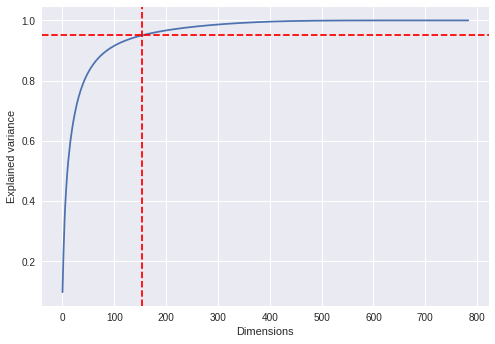

In [8]:
pca_plot = PCA().fit(X)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained variance')
plt.axvline(x=154, color='r', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')

## **Applying Random Forest**

Each function below fits a Random Forest Classifer, each with the same parameters, to the training set (features and labels) and evaluates the predictive accuracy with an F1 score.

The F1 score is the harmonic mean between precision and recall and is preferred for multi-class/multi-label classification problems. In multi-class classification this is the average of each class with weighting dependent on the `average` parameter. Setting this parameter to 'weighted' calculates the metrics for each label and finds their average weighted by support (i.e., the number of true instances of each label).

$F1 = 2 * (precision * recall)/(precision + recall)$

The `class_weight` parameter in the Random Forest Classifier is required for multi-class/multi-label targets. Setting this parameter to 'balanced' uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as: `n_samples / (n_classes * np.bincount(y))`. The weights are computed based on the bootstrap sample for every tree grown

## **PCA & Random Forest Pipeline**

This function creates a two-step pipeline  which (1) reduces the dimensionality to 154 componenets using PCA and (2) applies a Random Forest Classifier for multi-class classification

In [9]:
@simple_time_tracker(_log)
def PCA_RF_pipe_(X_train,y_train,X_test,y_test):
    pipe = Pipeline([('pca', PCA(n_components=154)),
                 ('rf', RandomForestClassifier(n_estimators=500,max_leaf_nodes=16, n_jobs=-1,
                                               max_features='sqrt', bootstrap=True, 
                                               class_weight="balanced_subsample"))])
    pipe.fit(X_train,y_train)
    eval_test = pipe.predict(X_test)
    jt = f1_score(y_test, eval_test, average='weighted')
    return jt
  
pipe = PCA_RF_pipe_(X_train,y_train2,X_test,y_test)
pipe

[SimpleTimeTracker] PCA_RF_pipe_ 194.490


0.8245560533035341

## **PCA Compression & Reconstruction Error**

After applying PCA to the dataset, the training set is easier to process becasue it takes up less space. We saw earlier that 19.6% (154/784) of the features preserve 95% of the variance in the data. The tradeoff to compression is that some of the data is lost. By decompressing the PCA compression, we can fit the same Random Forest Classifier to understand the F1 classification score .

The function below compresses the training data using PSA, then decompresses the data and applies Random Forest. 

In [10]:
@simple_time_tracker(_log)
def compress_decompress_RF_fit(X_train,y_train,X_test,y_test):
    pca = PCA(n_components=154)
    X_reduced = pca.fit_transform(X_train)
    X_recovered = pca.inverse_transform(X_reduced)
    rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16, n_jobs=-1,
                                 max_features='sqrt', bootstrap=True, class_weight="balanced_subsample")
    
    rnd_clf.fit(X_recovered, y_train)
    y_pred_decompression = rnd_clf.predict(X_test)
    decompress_f1 = f1_score(y_test, y_pred_decompression, average='weighted')
    
    return decompress_f1
  
decompressed = compress_decompress_RF_fit(X_train, y_train2, X_test, y_test)
decompressed

[SimpleTimeTracker] compress_decompress_RF_fit 382.554


0.8167210113850047

# **Results**

The dataframe below shows the execution time and F1 scores for the three models. As is listed, when compared to Random Forest models with PCA, Random Forest alone is executed much quicker and yields a better F1 score. 

### **PCA is generally not a good predecessor for Random Forests for a couple reasons:**


1.   PCA reduces the number of features. This model had enough observations (70,000) for Random Forests to handle its original features (784) 

2.   Random Forests do not perform well when the input features are transformations of other features, becuase this makes the individual trees in the forest less            independent of each other. 

3.   PCA gets rid of multi-collinearity by combining them into a single componenet. This is unecessary because Random Forests deal with collinearity



In [15]:
from collections import OrderedDict
data = OrderedDict([('Model',['Random Forest','PCA & RF Pipe','Decompressed RF']),
                    ('Execution Time', [60.87, 194.49, 382.55]),
                    ('F1 Score', [0.8415,round(pipe,4),round(decompressed,4)])])
df = pd.DataFrame.from_dict(data)
df

,Model,Execution Time,F1 Score
0,Random Forest,60.87,0.8415
1,PCA & RF Pipe,194.49,0.8246
2,Decompressed RF,382.55,0.8167
